In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings

from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import quantile_transform
from sklearn import linear_model

%matplotlib inline
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")


In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


In [3]:
display(houseprices_df.head(10))

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


In [4]:
print(houseprices_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [5]:
display(houseprices_df.describe())

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [6]:
houseprices_df.isnull().sum()

id                  0
mssubclass          0
mszoning            0
lotfrontage       259
lotarea             0
street              0
alley            1369
lotshape            0
landcontour         0
utilities           0
lotconfig           0
landslope           0
neighborhood        0
condition1          0
condition2          0
bldgtype            0
housestyle          0
overallqual         0
overallcond         0
yearbuilt           0
yearremodadd        0
roofstyle           0
roofmatl            0
exterior1st         0
exterior2nd         0
masvnrtype          8
masvnrarea          8
exterqual           0
extercond           0
foundation          0
                 ... 
bedroomabvgr        0
kitchenabvgr        0
kitchenqual         0
totrmsabvgrd        0
functional          0
fireplaces          0
fireplacequ       690
garagetype         81
garageyrblt        81
garagefinish       81
garagecars          0
garagearea          0
garagequal         81
garagecond         81
paveddrive

In [7]:
#finding our object and numeric columns
non_object = houseprices_df.select_dtypes(exclude=['object']).columns
object_columns = houseprices_df.select_dtypes(['object']).columns
print(non_object)
print(object_columns)

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'he

In [8]:
sum_null = houseprices_df.isnull().sum().sort_values(ascending=False)
percent_null = (houseprices_df.isnull().sum()/ len(houseprices_df)).sort_values(ascending=False)
print(sum_null, '\n', percent_null)

poolqc           1453
miscfeature      1406
alley            1369
fence            1179
fireplacequ       690
lotfrontage       259
garagecond         81
garagetype         81
garageyrblt        81
garagefinish       81
garagequal         81
bsmtexposure       38
bsmtfintype2       38
bsmtfintype1       37
bsmtcond           37
bsmtqual           37
masvnrarea          8
masvnrtype          8
electrical          1
utilities           0
yearremodadd        0
mssubclass          0
foundation          0
extercond           0
exterqual           0
exterior2nd         0
exterior1st         0
roofmatl            0
roofstyle           0
yearbuilt           0
                 ... 
garagearea          0
paveddrive          0
wooddecksf          0
openporchsf         0
threessnporch       0
bsmtunfsf           0
screenporch         0
poolarea            0
miscval             0
mosold              0
yrsold              0
saletype            0
functional          0
totrmsabvgrd        0
kitchenqua

Since there are only 19 out of 81 columns that are null so we'll do our analysis without those variables.

Text(0.5, 1.0, '')

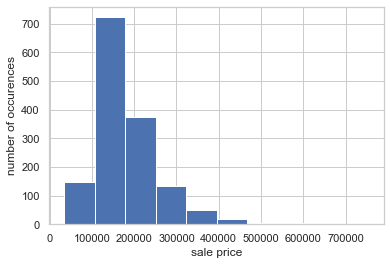

In [9]:
#exploring saleprice
plt.hist(houseprices_df.saleprice)
plt.xlabel('sale price')
plt.ylabel('number of occurences')
plt.title('')

In [10]:
for col in non_object:
    q75, q25 = np.percentile(houseprices_df[col], [75 ,25])
    iqr = q75 - q25

    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print("Number of outliers and percentage of it in {} : {} and %{}".format(col,
                                                                             len((np.where((houseprices_df[col] > max_val) | 
                                                                                           (houseprices_df[col] < min_val))[0])),len((np.where((houseprices_df[col] > max_val) | 
                                                                                           (houseprices_df[col] < min_val))[0]))*100/1460))

Number of outliers and percentage of it in id : 0 and %0.0
Number of outliers and percentage of it in mssubclass : 103 and %7.054794520547945
Number of outliers and percentage of it in lotfrontage : 0 and %0.0
Number of outliers and percentage of it in lotarea : 69 and %4.726027397260274
Number of outliers and percentage of it in overallqual : 2 and %0.136986301369863
Number of outliers and percentage of it in overallcond : 125 and %8.561643835616438
Number of outliers and percentage of it in yearbuilt : 7 and %0.4794520547945205
Number of outliers and percentage of it in yearremodadd : 0 and %0.0
Number of outliers and percentage of it in masvnrarea : 0 and %0.0
Number of outliers and percentage of it in bsmtfinsf1 : 7 and %0.4794520547945205
Number of outliers and percentage of it in bsmtfinsf2 : 167 and %11.438356164383562
Number of outliers and percentage of it in bsmtunfsf : 29 and %1.9863013698630136
Number of outliers and percentage of it in totalbsmtsf : 61 and %4.1780821917808

In [11]:
# looking at correlation of continuous variables compared to our target variable of saleprice
print(houseprices_df[non_object].iloc[:, 1:].corr(
).loc[:, 'saleprice'].sort_values(ascending=False)
)

top_ten = houseprices_df[['saleprice', 'overallqual', 'grlivarea', 'garagecars',
                          'garagearea', 'totalbsmtsf', 'firstflrsf', 'fullbath',
                          'totrmsabvgrd', 'yearbuilt', 'yearremodadd']]



saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
threessnporch    0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: saleprice, dtype: float64


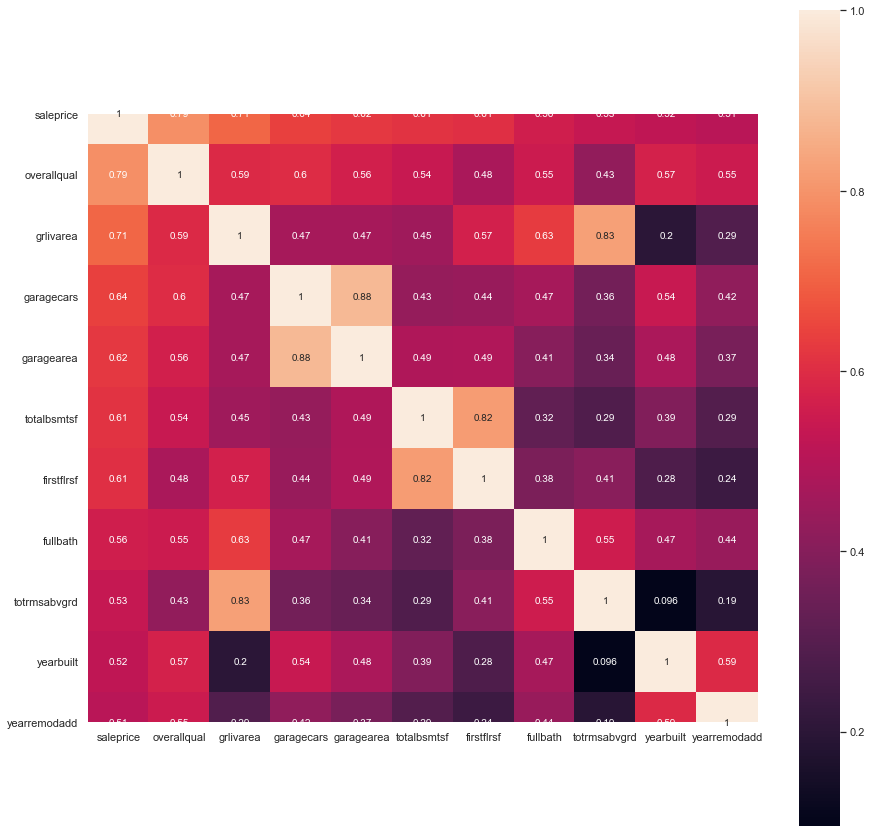

In [12]:
plt.figure(figsize=(15,15))
sns.heatmap(top_ten.corr(), square=True, annot=True)
#looking at our top ten correlated variables, we can see that only garagecars and garagearea
#have really strong correlation with each other so we'll drop garagearea

In [13]:
top_five = houseprices_df[['saleprice', 
                           'overallqual', 
                           'grlivarea', 
                           'garagecars',
                           'totalbsmtsf']]

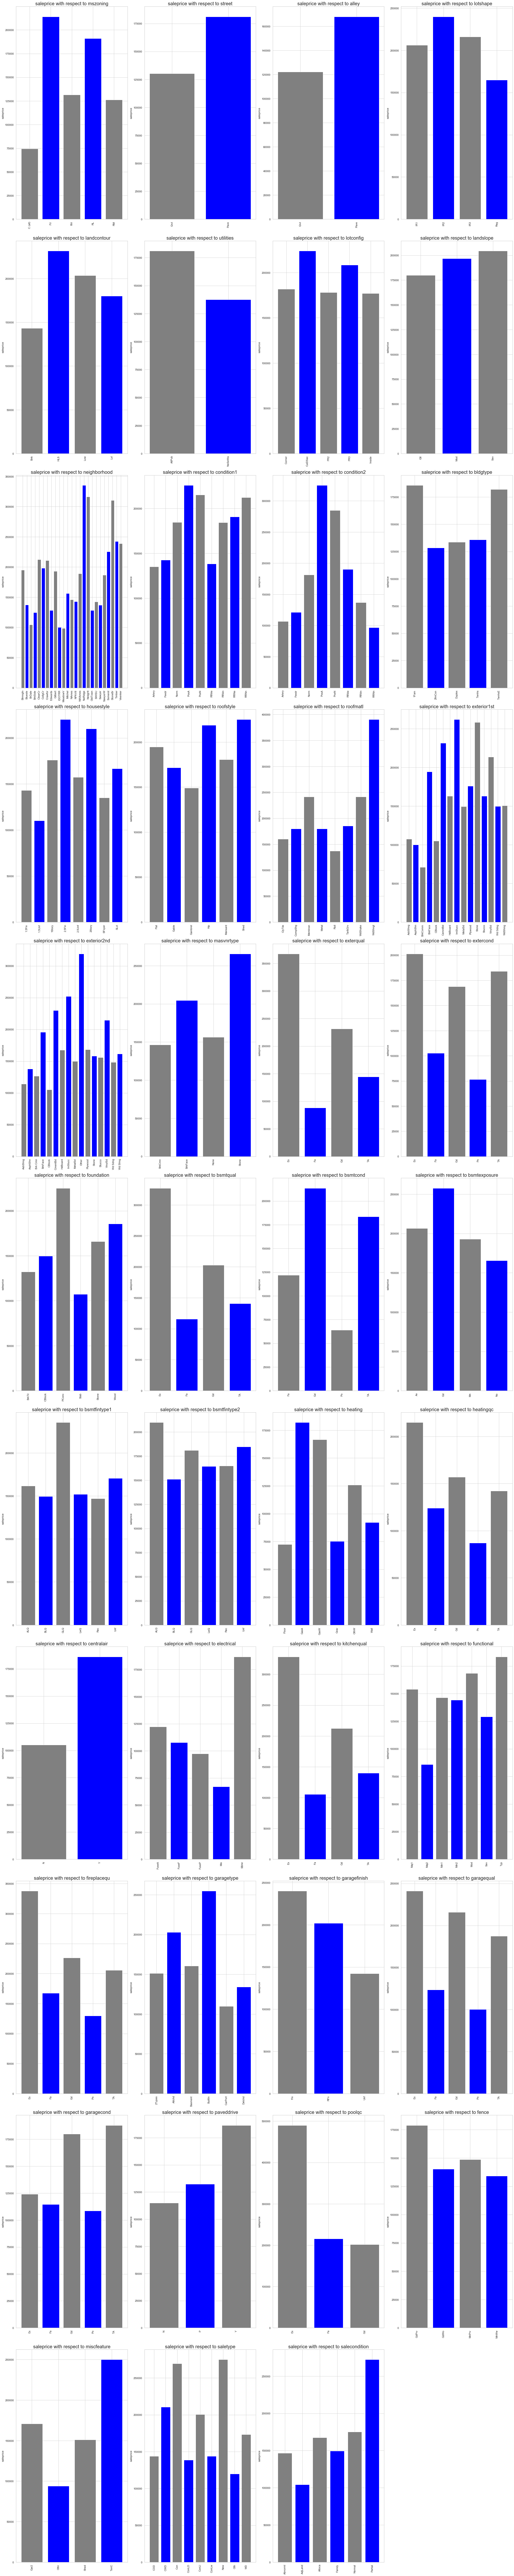

In [14]:
# take a look at our object variables
plt.figure(figsize=(30, 150))
for i, col in enumerate(object_columns):
    plt.subplot(11, 4, i+1)
    plt.bar(houseprices_df.groupby(col)['saleprice'].mean(
    ).index, houseprices_df.groupby(col)['saleprice'].mean(), color=('grey', 'blue'))
    plt.ylabel('saleprice')
    plt.xticks(rotation='vertical')
    plt.title('saleprice with respect to {}'.format(col), fontsize=20)
    plt.tight_layout()

In [25]:
# street, utilities, and centralair all have a pretty big impact on saleprice so
# we'll get dummies and add them to the feature dataframe
houseprices_df['dummy_street'] = pd.get_dummies(houseprices_df['street'], prefix='street', drop_first=True)

houseprices_df['dummy_utilities'] = pd.get_dummies(houseprices_df['utilities'], prefix='utilities', drop_first=True)

houseprices_df['dummy_centralair'] = pd.get_dummies(houseprices_df['centralair'], prefix='centralair', drop_first=True)

In [28]:
X = houseprices_df[['saleprice',
                    'overallqual',
                    'grlivarea',
                    'garagecars',
                    'totalbsmtsf',
                    'dummy_street',
                    'dummy_centralair']]

Y = houseprices_df['saleprice']

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()
# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [ 1.00000000e+00 -4.00390419e-14  7.47737923e-17  1.13570284e-14
  2.72124798e-16 -2.72407636e-12  4.09615931e-13]

Intercept: 
 -8.731149137020111e-11


In [29]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.584e+32
Date:                Sat, 26 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:23:58   Log-Likelihood:                 31686.
No. Observations:                1460   AIC:                        -6.336e+04
Df Residuals:                    1452   BIC:                        -6.331e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -2.91e-11    3.9e-11     -0.746      0.456   -1.06e-10    4.74e-11
saleprice            1.0000   6.16e-17   1.62e+16      0.000       1.000       1.000
overallqual      -1.546e-11   2.92e-12     -5.294      0.000   -2.12e-11   -9.73e-12
grlivarea        -1.954e-14   6.52e-15     -2.997      0.003   -3.23e-14   -6.75e-15
garagecars       -3.183e-12   4.27e-12     -0.745      0.456   -1.16e-11     5.2e-12
totalbsmtsf      -2.442e-14   6.95e-15     -3.512      0.000   -3.81e-14   -1.08e-14
dummy_street     -1.455e-11   3.75e-11     -0.388      0.698   -8.82e-11    5.91e-11
dummy_centralair -2.376e-11   1.02e-11     -2.322      0.020   -4.38e-11   -3.69e-12
==============================================================================
Omnibus:                      791.209   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6855.190
Skew:                          -2.396   Prob(JB):                         0.00
Kurtosis:                      12.473   Cond. No.                     4.41e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
lrm.fit(X,Y)
predictions = lrm.predict(X)
# we print the estimated coefficients
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

errors = Y - predictions
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))


Coefficients: 
 [ 0.00000000e+00  1.00000000e+00  9.45691274e-12 -5.47779542e-20
  2.01689251e-13 -3.71545094e-15  1.90240802e-11  7.80086935e-15]

Intercept: 
 -5.820766091346741e-11
Mean of the errors in the medical costs model is: 1.7716458437275397e-11


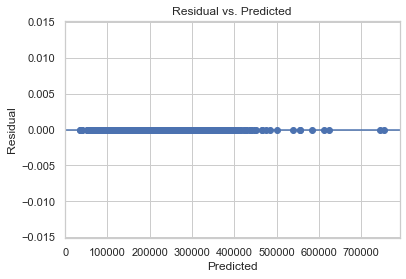

In [31]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [32]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 102405 and p value is 0
Levene test statistic value is 1269.63 and p value is 3.43e-231


My model is heteroscedastic. Most likely due to normality issues and outliers in the dependent variables.